# Average K-Means
We investigate a k-means clustering variant where we upweight the within-class sum of squares for the minority class, and downweight the WCSS for the majority. In effect we switch WCSS for within-class mean-square-residual, hence the name "average k-means".

The usual k-means procedure (Lloyd's algorithm) cannot be modified to optimize the average k-means objective. Possible ways to solve it:
* Sequentially test splits along PC1, PC2, … PC_d
    * Under what conditions will the optimal split be somewhere on a PC?
* A graph algorithm (Bradley, Bennett, Demiriz; or https://en.wikipedia.org/wiki/Kernighan%E2%80%93Lin_algorithm)
* A conic programming algorithm (Rujeerapaiboon et al)
* A genetic algorithm (Krishna & Murty, 


In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [297]:
import scipy.stats

In [284]:
import sigclust

In [285]:
from importlib import reload

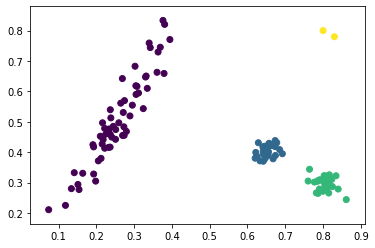

In [298]:
toy = pd.read_csv('examples/sigclust_toy_data.csv', header=None)
toy = toy.T
toy.columns = ['label', 'x1', 'x2']
plt.scatter(toy['x1'], toy['x2'], c=toy['label'])

## Definitions of CI and Avg CI

$$\begin{aligned}
CI &= \frac{\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \sum_{x \in C_2} ||x- \bar{x}_2||^2}{\sum ||x-\bar{x}||^2} \\
Avg CI &= \frac{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}||^2}
\end{aligned}$$

Observe that both must live on $[0,1]$.

### Functions for computing these criteria from given splits:

In [299]:
def compute_average_cluster_index_numerator(class_1, class_2):
    """Compute the average cluster index for the two given classes"""
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    class_1_MSE = sigclust.compute_sum_of_square_distances_to_mean(class_1) / n1
    class_2_MSE = sigclust.compute_sum_of_square_distances_to_mean(class_2) / n2
    return class_1_MSE + class_2_MSE

In [300]:
def compute_average_cluster_index(class_1, class_2):
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) / n1 + 
                   sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean) / n2 )
    numerator = compute_average_cluster_index_numerator(class_1, class_2)
    return numerator/denominator

In [301]:
def compute_cluster_index_numerator(class_1, class_2):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    return class_1_SSE + class_2_SSE

def compute_cluster_index(class_1, class_2):
    numerator = compute_cluster_index_numerator(class_1, class_2)
    denominator = sigclust.compute_sum_of_square_distances_to_mean(np.concatenate([class_1, class_2]))
    return numerator/denominator


### Function to plot all criteria as a function of where you split on PC1
Note: interesting research idea: under what regularity conditions can we find the optimal split somewhere on a PC direction?

In [302]:
def plot_criteria(data):
    scores = PCA().fit_transform(data)
    scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2'], index=data.index)
    
    pc1 = scores_df['PC1']
    
    def split_data_by_score(score):
        class_1 = data[pc1 <= score]
        class_2 = data[pc1 > score]
        return (class_1, class_2)
    
    def compute_avg_ci_numerator_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        return compute_average_cluster_index_numerator(class_1, class_2)
    
    def compute_avg_ci_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        return compute_average_cluster_index(class_1, class_2)
    
    def compute_ci_by_score(score):
        class_1, class_2 = split_data_by_score(score)
        ci = compute_cluster_index(class_1, class_2)
        return ci
    
    
    avg_ci_numerators = pc1.map(compute_avg_ci_numerator_by_score)
    avg_cis = pc1.map(compute_avg_ci_by_score)
    cis = pc1.map(compute_ci_by_score)
    
    criteria_df = pd.DataFrame({'PC1': pc1, 'ci': cis, 'avg_ci': avg_cis, 'avg_ci_numerator': avg_ci_numerators}).sort_values('PC1')
    criteria_df2 = criteria_df.set_index('PC1')
    
#     fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
#     ax1.scatter(scores_df['PC1'], scores_df['PC2'])
#     ax1.axhline(0, color='black')
#     ax1.set_xlabel('PC1 score')
#     ax1.set_ylabel('PC2 score')
#     for x in scores_df['PC1']:
#         ax0.axvline(x, alpha=0.1, color='gray')
#         ax1.axvline(x, alpha=0.1, color='gray')

    fig, axs = plt.subplots(4, 1, figsize=(5,5), sharex=True)
    axs[-1].scatter(scores_df['PC1'], scores_df['PC2'])
    axs[-1].axhline(0, color='black')
    axs[-1].set_xlabel('PC1 score')
    axs[-1].set_ylabel('PC2')
    #axs[-1].axis('square')
    for x in scores_df['PC1']:
        for ax in axs:
            ax.axvline(x, alpha=0.1, color='gray')
            
    axs[0].plot(criteria_df['PC1'], criteria_df['ci'])
    axs[0].set_title("Cluster Index")
    
    axs[1].plot(criteria_df['PC1'], criteria_df['avg_ci'])
    axs[1].set_title("Avg Cluster Index")
    
    axs[2].plot(criteria_df['PC1'], criteria_df['avg_ci_numerator'])
    axs[2].set_title("Avg Cluster Index Numerator")
    
    fig.tight_layout()
    

    
#     criteria_df2.plot(kind='line', ax=ax0)
#     ax0.plot(criteria_df['PC1'], criteria_df['criterion'])
#     ax0.set_ylabel("Criterion")
#     ax0.set_title("Criterion by PC1 split")
    
#     min_criteria_row = criteria_df.sort_values('criterion').iloc[0]
#     ax0.scatter(min_criteria_row['PC1'], min_criteria_row['criterion'], color='red')
#     ax0.axvline(min_criteria_row['PC1'], color='red', alpha=0.5)
#     ax1.axvline(min_criteria_row['PC1'], color='red', alpha=0.5)

## Long gaussian plus two outliers

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


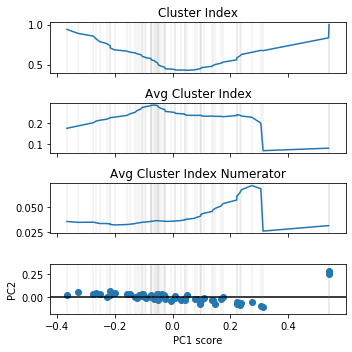

In [303]:
stretched_gaussian_plus_outliers = toy[toy['label'].isin([1,4])]
plot_criteria(stretched_gaussian_plus_outliers[['x1','x2']])

The Avg CI and Avg CI Numerator give the desired split.

## Long gaussian alone

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


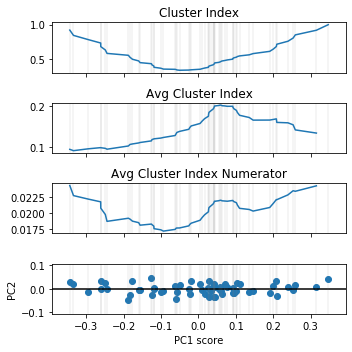

In [383]:
long_gaussian = toy[toy['label']==1][['x1','x2']]
plot_criteria(long_gaussian)

It doesn't seem like good news for the Avg CI that the minima are at the end points. The Avg CI Numerator is more wobbly, which will be sensitive to noise.

## Gaussian with a lot more points

In [16]:
large_gaussian_sample = np.random.multivariate_normal((0,0), np.cov(long_gaussian.T), 5000)

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


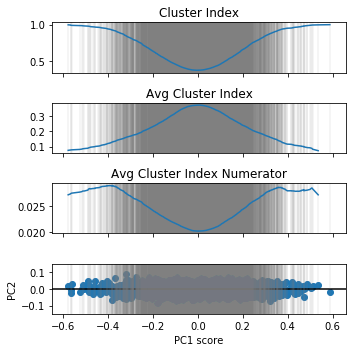

In [17]:
plot_criteria(pd.DataFrame(large_gaussian_sample))

## Both spherical clusters

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


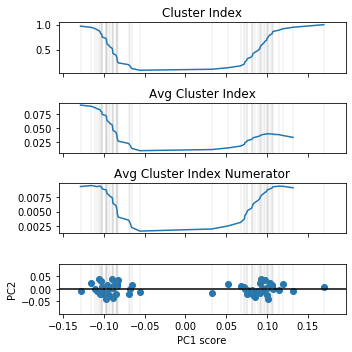

In [386]:
sphericals = toy[toy['label'].isin([2,3])]
plot_criteria(sphericals[['x1','x2']])

## Long gaussian plus both sphericals

/Users/thomaskeefe/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


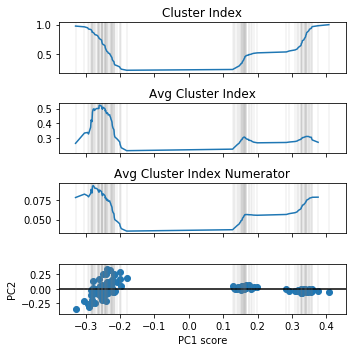

In [117]:
data = toy[toy['label'].isin([1,2,3])][['x1', 'x2']]
plot_criteria(data)

# Flattening the CI curve

$$\begin{aligned}
CI &= \frac{\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \sum_{x \in C_2} ||x- \bar{x}_2||^2}{\sum ||x-\bar{x}||^2} \\ \\
Avg CI &= \frac{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|}\sum_{x \in C_2} ||x- \bar{x}||^2} \\ \\
Avg CI_p &= \frac{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}_1||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}_2||^2}{\frac{1}{|C_1|^p}\sum_{x \in C_1} ||x- \bar{x}||^2 + \frac{1}{|C_2|^p}\sum_{x \in C_2} ||x- \bar{x}||^2} 
\end{aligned}$$

When $p = 0$ the new $Avg CI_p$ is CI, and when $p = 1$ it is $Avg CI$. Furthermore, when the classes are balanced, the exponent p doesn't do anything.

In [60]:
def avg_cluster_index_p_exp(class_1, class_2, p):
    class_1_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_1)
    class_2_SSE = sigclust.compute_sum_of_square_distances_to_mean(class_2)
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    overall_mean = np.concatenate([class_1, class_2]).mean()
    
    numerator = (1/n1)**p * class_1_SSE + (1/n2)**p * class_2_SSE
    denominator = (sigclust.compute_sum_of_square_distances_to_point(class_1, overall_mean) / n1**p + 
                   sigclust.compute_sum_of_square_distances_to_point(class_2, overall_mean) / n2**p )
    return numerator/denominator
    

In [123]:
Z = scipy.stats.norm.ppf(np.linspace(0.001, .999, 5000))

In [124]:
#fig, (ax0, ax1) = plt.subplots(2)

results = pd.DataFrame({'Z': Z})
cis = []
for p in np.linspace(0,1,40):
    cis = []
    for i in range(len(Z)-1):
        class_1 = Z[:i+1, np.newaxis]
        class_2 = Z[i+1:, np.newaxis]
        ci = avg_cluster_index_p_exp(class_1, class_2, p)
        cis.append(ci)
    
    cis.append(cis[-1])
    results[p] = cis

    


In [125]:
resultsZ = results.set_index('Z')

In [126]:
resultsZ.head()

,0.000000,0.025641,0.051282,0.076923,0.102564,0.128205,0.153846,0.179487,0.205128,0.230769,...,0.769231,0.794872,0.820513,0.846154,0.871795,0.897436,0.923077,0.948718,0.974359,1.000000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,0.998052,0.997578,0.996989,0.996257,0.995348,0.994219,0.992819,0.991082,0.988929,0.986265,...,0.422604,0.370406,0.321069,0.275430,0.234041,0.197180,0.164874,0.136959,0.113129,0.092999
-3.035763,0.996173,0.995327,0.994295,0.993036,0.991503,0.989635,0.987362,0.984599,0.981242,0.977170,...,0.387946,0.341519,0.297945,0.257755,0.221280,0.188656,0.159856,0.134725,0.113015,0.094424
-2.989039,0.994350,0.993175,0.991757,0.990048,0.987989,0.985510,0.982529,0.978946,0.974648,0.969499,...,0.369387,0.326296,0.285955,0.248764,0.214956,0.184618,0.157705,0.134075,0.113513,0.095760
-2.948051,0.992576,0.991102,0.989337,0.987226,0.984704,0.981693,0.978102,0.973826,0.968740,0.962704,...,0.357159,0.316387,0.278259,0.243097,0.211084,0.182277,0.156627,0.134002,0.114209,0.097019
-2.911488,0.990846,0.989094,0.987010,0.984534,0.981595,0.978109,0.973979,0.969096,0.963329,0.956535,...,0.348271,0.309260,0.272796,0.239149,0.208470,0.180799,0.156086,0.134205,0.114983,0.098212


## $Avg CI_p$ for different values of $p$ on a large $N(0,1)$ population:

(0, 1)

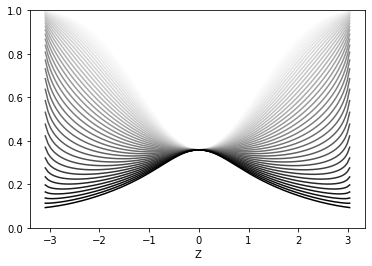

In [127]:
fig, ax = plt.subplots()
im = resultsZ.iloc[:-1, :].plot(kind='line', colormap='Greys', legend=False, ax=ax)
ax.set_ylim(0, 1)

Zoom in on some values of $p$ where the curve is flattest:

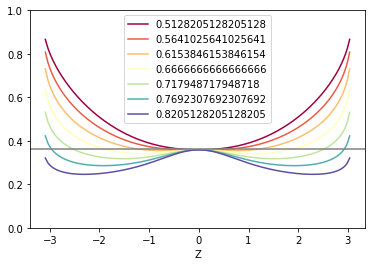

In [128]:
fig, ax = plt.subplots()
resultsZ.iloc[:-1, 20:33:2].plot(kind='line', ax=ax, colormap='Spectral')
ax.set_ylim(0,1)
ax.axhline(0.36338, color='gray')

### Try to make the second derivative at 0 equal to 0:

In [133]:
first_derivative = (resultsZ.shift(-1) - resultsZ) * 5000/.998

In [143]:
second_derivative = (first_derivative.shift(-1) - first_derivative) * 5000/.998

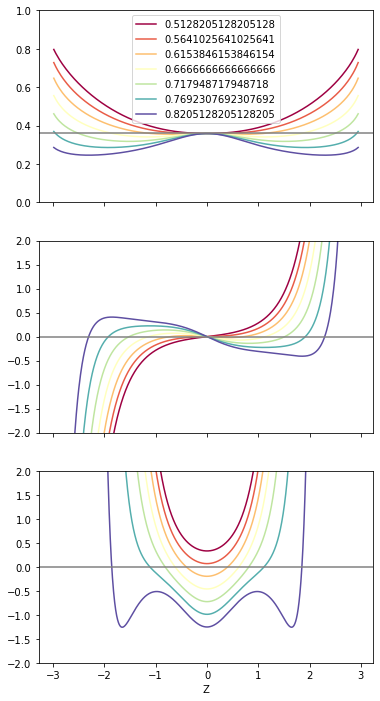

In [279]:
fig, axs = plt.subplots(3, figsize=(6,12), sharex=True)
resultsZ.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[0], colormap='Spectral')
axs[0].set_ylim(0,1)
axs[0].axhline(0.36338, color='gray')

first_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[1], colormap='Spectral', legend=False)

axs[1].set_ylim(-2, 2)
axs[1].axhline(0, color='gray')

second_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[2], colormap='Spectral', legend=False)

axs[2].set_ylim(-2, 2)
axs[2].axhline(0, color='gray')

#### Plot $f''(0)$ as a function of $p$

Text(0.5, 1.0, "f''(0) as function of p")

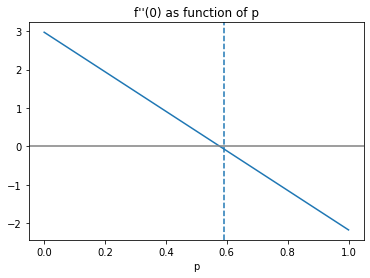

In [184]:
second_derivative.loc[0.00025021154672772247].plot(kind='line')
optimal_p = second_derivative.loc[0.00025021154672772247].abs().idxmin()
plt.xlabel('p')
plt.axhline(0, color='gray')
plt.axvline(optimal_p, linestyle='--')
plt.title("f''(0) as function of p")

In [186]:
optimal_p

0.5897435897435898

### Try to make the first derivative zero

In [187]:
first_derivative

,0.000000,0.025641,0.051282,0.076923,0.102564,0.128205,0.153846,0.179487,0.205128,0.230769,...,0.769231,0.794872,0.820513,0.846154,0.871795,0.897436,0.923077,0.948718,0.974359,1.000000
Z,,,,,,,,,,,,,,,,,,,,,
-3.090232,-9.418584,-11.281604,-13.499797,-16.136365,-19.264114,-22.966256,-27.336956,-32.481462,-38.515519,-45.563731,...,-173.635774,-144.721534,-115.854796,-88.549828,-63.935993,-42.705785,-25.141231,-11.191546,-0.572167,7.138571
-3.035763,-9.132407,-10.780701,-12.711909,-14.969818,-17.603314,-20.666319,-24.217398,-28.318868,-33.035234,-38.430679,...,-92.982522,-76.268119,-60.067354,-45.048250,-31.680440,-20.228653,-10.774454,-3.254848,2.493334,6.691592
-2.989039,-8.884748,-10.386931,-12.127697,-14.140017,-16.459740,-19.125190,-22.176437,-25.654106,-29.597607,-34.042585,...,-61.260586,-49.644414,-38.559085,-28.391182,-19.402069,-11.729378,-5.402808,-0.367990,3.487333,6.309016
-2.948051,-8.666582,-10.057302,-11.655182,-13.486068,-15.577365,-17.957475,-20.654937,-23.697165,-27.108683,-30.908742,...,-44.530121,-35.706973,-27.371365,-19.778111,-13.094285,-7.402555,-2.713062,1.020108,3.881334,5.977298
-2.911488,-8.471723,-9.772361,-11.256194,-12.943962,-14.857099,-17.017106,-19.444648,-22.158298,-25.172868,-28.497242,...,-34.323443,-27.254742,-20.624362,-14.613923,-9.339462,-4.855064,-1.162118,1.778504,4.033694,5.686445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.911488,8.884748,10.386931,12.127697,14.140017,16.459740,19.125190,22.176437,25.654106,29.597607,34.042585,...,61.260586,49.644414,38.559085,28.391182,19.402069,11.729378,5.402808,0.367990,-3.487333,-6.309016
2.948051,9.132407,10.780701,12.711909,14.969818,17.603314,20.666319,24.217398,28.318868,33.035234,38.430679,...,92.982522,76.268119,60.067354,45.048250,31.680440,20.228653,10.774454,3.254848,-2.493334,-6.691592
2.989039,9.418584,11.281604,13.499797,16.136365,19.264114,22.966256,27.336956,32.481462,38.515519,45.563731,...,173.635774,144.721534,115.854796,88.549828,63.935993,42.705785,25.141231,11.191546,0.572167,-7.138571


In [200]:
from scipy.linalg import norm

In [203]:
L1_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, 1))

In [204]:
L2_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, 2))
Linf_norms = first_derivative.iloc[2:-2].apply(lambda f: norm(f, np.inf))

[Text(0, 0, '0'), Text(0, 0, '0.97'), Text(0, 0, '1')]

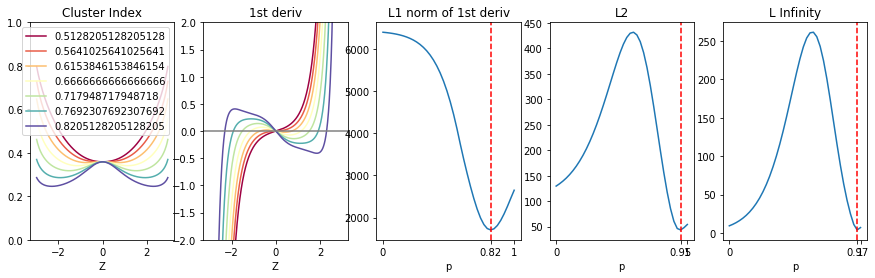

In [395]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
resultsZ.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[0], colormap='Spectral')
axs[0].set_ylim(0,1)
axs[0].set_title("Cluster Index")

first_derivative.iloc[2:-3, 20:33:2].plot(kind='line', ax=axs[1], colormap='Spectral', legend=False)
axs[1].set_ylim(-2, 2)
axs[1].axhline(0, color='gray')
axs[1].set_title("1st deriv")

axs[2].plot(L1_norms.index, L1_norms)
axs[2].set_xlabel('p')
axs[2].set_title("L1 norm of 1st deriv")
axs[2].axvline(L1_norms.idxmin(), color='red', linestyle='--')
axs[2].set_xticks([0, L1_norms.idxmin(), 1])
axs[2].set_xticklabels(["0", f"{L1_norms.idxmin():.2f}", "1"])

axs[3].plot(L2_norms.index, L2_norms)
axs[3].set_xlabel('p')
axs[3].set_title("L2")
axs[3].axvline(L2_norms.idxmin(), color='red', linestyle='--')
axs[3].set_xticks([0, L2_norms.idxmin(), 1])
axs[3].set_xticklabels(["0", f"{L2_norms.idxmin():.2f}", "1"])

axs[4].plot(Linf_norms.index, Linf_norms)
axs[4].set_xlabel('p')
axs[4].set_title("L Infinity")
axs[4].axvline(Linf_norms.idxmin(), color='red', linestyle='--')
axs[4].set_xticks([0, Linf_norms.idxmin(), 1])
axs[4].set_xticklabels(["0", f"{Linf_norms.idxmin():.2f}", "1"])



### So which approach has the most power?

In [291]:
import sigclust.sigclust

In [354]:
reload(sigclust.sigclust)

<module 'sigclust.sigclust' from '/Users/thomaskeefe/Documents/sigclust/sigclust/sigclust.py'>

In [398]:
sigclusts = []
for i in range(6):
    p = i/5
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=1000)
    sc.fit(stretched_gaussian_plus_outliers[['x1','x2']], stretched_gaussian_plus_outliers['label'], p=p)
    sigclusts.append(sc)

Text(0.5, 0.98, 'Stretched gaussian plus 2 outliers, using known labels')

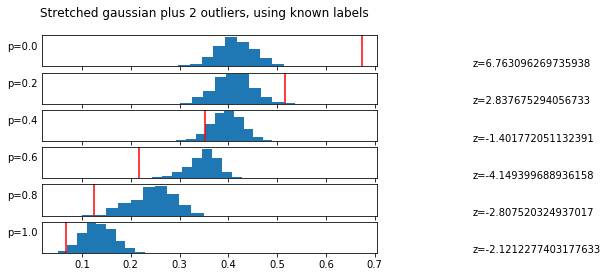

In [399]:
fig, axs = plt.subplots(6, sharex=True)
for i in range(6):
    sc = sigclusts[i]
    axs[i].hist(sc.simulated_cluster_indices)
    axs[i].axvline(sc.sample_cluster_index, color='red')
    axs[i].set_ylabel(f"p={i/5}", rotation=0, labelpad=20)
    axs[i].get_yaxis().set_ticks([])
    z = sc.z_score
    axs[i].text(0.9, 0.5, f"z={z}")
    
fig.suptitle("Stretched gaussian plus 2 outliers, using known labels")

### Two spherical clusters

In [400]:
sigclusts = []
for i in range(6):
    p = i/5
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=1000)
    sc.fit(sphericals[['x1','x2']], sphericals['label'], p=p)
    sigclusts.append(sc)

Text(0.5, 0.98, 'Two spherical clusters, using known labels')

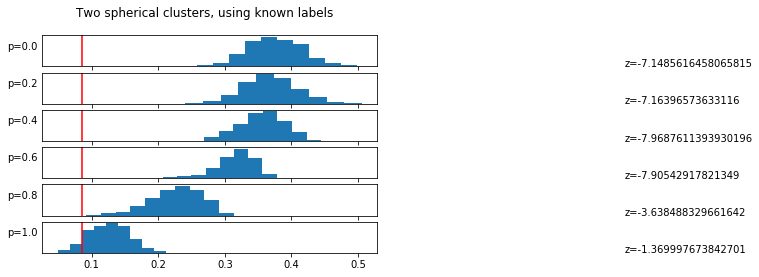

In [401]:
fig, axs = plt.subplots(6, sharex=True)
for i in range(6):
    sc = sigclusts[i]
    axs[i].hist(sc.simulated_cluster_indices)
    axs[i].axvline(sc.sample_cluster_index, color='red')
    axs[i].set_ylabel(f"p={i/5}", rotation=0, labelpad=20)
    axs[i].get_yaxis().set_ticks([])
    z = sc.z_score
    axs[i].text(0.9, 0.5, f"z={z}")
    
fig.suptitle("Two spherical clusters, using known labels")

### Stretched gaussian alone

In [396]:
sigclusts = []
labels = np.concatenate([np.repeat(1, 30), np.repeat(2, 30)])
for i in range(6):
    p = i/5
    sc = sigclust.sigclust.AvgCISigClust(num_simulations=200)
    sc.fit(hotdog.values, labels, p=p)
    sigclusts.append(sc)

Text(0.5, 0.98, 'Stretched gaussian alone, balanced random labeling')

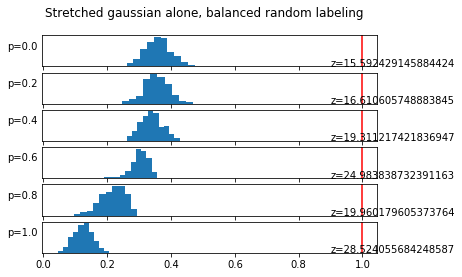

In [397]:
fig, axs = plt.subplots(6, sharex=True)
for i in range(6):
    sc = sigclusts[i]
    axs[i].hist(sc.simulated_cluster_indices)
    axs[i].axvline(sc.sample_cluster_index, color='red')
    axs[i].set_ylabel(f"p={i/5}", rotation=0, labelpad=20)
    axs[i].get_yaxis().set_ticks([])
    z = sc.z_score
    axs[i].text(0.9, 0.5, f"z={z}")
    
fig.suptitle("Stretched gaussian alone, balanced random labeling")